Rough volatility models

Authors: <span class="mark">Runbo</span> NI & <span class="girk">Ge</span> ZHU

# Fractional Brownian Motion

## Wood-Chan Circulant Method

To simulate the fractional Brownian Motion (fBM), we first use a naive method introduced in the paper [FRACTIONAL BROWNIAN MOTION IN A NUTSHELL](https://arxiv.org/pdf/1406.1956.pdf).

As fBM $\left\{B_{t}^{H}, t \geq 0\right\}$ is simply a Gaussian process with continuous paths characterized by its covariance function
$$
\mathrm{E}\left[B_{t}^{H} B_{s}^{H}\right]=\frac{1}{2}\left(t^{2 H}+s^{2 H}-|t-s|^{2 H}\right)
$$

To get a copy at the points $t_{k}^{N}=k T / N, k=0,1, \ldots, N$ for some large $N$, since fBM is self-similar and has stationary increments, it suffices to simulate the increment at integer points, i.e. $\xi_{1}=B_{1}^{H}, \xi_{2}=B_{2}^{H}-B_{1}^{H}, \ldots, \xi_{N}=B_{N}^{H}-B_{N-1}^{H}$. $\xi_{1}, \xi_{2}, \ldots, \xi_{N}$ form a stationary sequence of standard Gaussian variables (fractional Gaussian noise) with covariance
$$
\rho_{H}(n)=\mathrm{E}\left[\xi_{1} \xi_{n+1}\right]=\frac{1}{2}\left((n+1)^{2 H}+(n-1)^{2 H}-2 n^{2 H}\right), n \geq 1
$$

We write out the covariance matrix of $\xi=\left(\xi_{1}, \ldots, \xi_{N}\right)^{\top}$:
$$
\operatorname{Cov}(\xi)=\left(\begin{array}{cccccc}{1} & {\rho_{H}(1)} & {\rho_{H}(2)} & {\dots} & {\rho_{H}(N-2)} & {\rho_{H}(N-1)} \\ {\rho_{H}(1)} & {1} & {\rho_{H}(1)} & {\dots} & {\rho_{H}(N-3)} & {\rho_{H}(N-2)} \\ {\rho_{H}(2)} & {\rho_{H}(1)} & {1} & {\cdots} & {\rho_{H}(N-4)} & {\rho_{H}(N-3)} \\ {\vdots} & {\vdots} & {\vdots} & {\ddots} & {\vdots} & {\vdots} \\ {\rho_{H}(N-2)} & {\rho_{H}(N-3)} & {\rho_{H}(N-4)} & {\dots} & {1} & {\rho_{H}(1)} \\ {\rho_{H}(N-1)} & {\rho_{H}(N-2)} & {\rho_{H}(N-3)} & {\dots} & {\rho_{H}(1)} & {1}\end{array}\right)
$$

THe key of the proof is to construct a circulant matrix, by extending the matrix into $M = 2(N-1)$ dimensional matrix $C$:
$$
\begin{array}{ll}{c_{0}=1} \\ {c_{k}=\left\{\begin{array}{ll}{\rho_{H}(k),} & {k=1,2, \ldots, N-1} \\ {\rho_{H}(M-k),} & {k=N, N+1, \ldots, M-1}\end{array}\right.}\end{array}
$$
and
$$
C=\operatorname{circ}\left(c_{0}, c_{1}, \ldots, c_{M-1}\right)=\left(\begin{array}{cccccc}{c_{0}} & {c_{1}} & {c_{2}} & {\ldots} & {c_{M-2}} & {c_{M-1}} \\ {c_{M-1}} & {c_{0}} & {c_{1}} & {\ldots} & {c_{M-3}} & {c_{M-2}} \\ {c_{M-2}} & {c_{M-1}} & {c_{0}} & {\ldots} & {c_{M-4}} & {c_{M-3}} \\ {\vdots} & {\vdots} & {\vdots} & {\ddots} & {\vdots} & {\vdots} \\ {c_{2}} & {c_{3}} & {c_{4}} & {\cdots} & {c_{0}} & {c_{1}} \\ {c_{1}} & {c_{2}} & {c_{3}} & {\cdots} & {c_{M-1}} & {c_{0}}\end{array}\right)
$$

To find a square root of this matrix in order to simulate $\xi$, it suffices to apply the properties of Discrete Fourier Transform (DFT) (shift, inversed DFT, see [EE 261 The Fourier Transform
and its Applications](https://see.stanford.edu/materials/lsoftaee261/Formulas.pdf)), and we could easily prove the Theorem 6.1 in the paper:


and $Q=\left(q_{j k}\right)_{j, k=0}^{M-1}$ (DFT operator, scaled by $\frac{1}{\sqrt{M}}$), where
$$q_{j k}=\frac{1}{\sqrt{M}} \exp \left\{-2 \pi i \frac{j k}{M}\right\}$$
we have
$$
\begin{array}{l}{\text { Theorem } 6.1 . \text { The circulant matrix } C \text { has a representation } C=Q \Lambda Q^{*}, \text { where}} \\ {\Lambda=\operatorname{diag}\left(\lambda_{0}, \lambda_{1}, \ldots, \lambda_{M-1}\right), \lambda_{k}=\sum_{j=0}^{M-1} c_{j} \exp \left\{-2 \pi i \frac{j k}{M}\right\} . \text { Consequently, } C=} \\ {S S^{*} \text { with } S=Q \Lambda^{1 / 2} Q^{*}, \Lambda^{1 / 2}=\operatorname{diag}\left(\lambda_{0}^{1 / 2}, \lambda_{1}^{1 / 2}, \ldots, \lambda_{M-1}^{1 / 2}\right)}\end{array}
$$.

With this theorem, now we have simulate a FBM.

In [11]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft # FFT
from scipy.linalg import dft # FFT matrix

In [14]:
class fbm:
    @staticmethod
    def cov_pointwise(H, s, t):
        '''
        Calculate the covariance of BH(s), BH(t)

        Parameters:
            H - Hurst exponent 
            s - time
            t - time

        Returns:
            The covariance of BH(s), BH(t)
        '''
        return 1/2 * (np.power(s, 2*H) + np.power(t, 2*H) - np.power(np.abs(s-t), 2*H))
    
    @staticmethod
    def cov(N, H):
        '''
        Calculates the covariance matrix of the increments of the fractional Brownian Motion 
        at integer points (xi_1, ..., xi_N)

        Parameters:
            N - the number of points 
            H - Hurst Exponent

        Returns:
            The covariance matrix of the vector (xi_1, ..., xi_N)
        '''

        # Calculate integers to power 2H
        power_list = np.power(np.arange(N+1), 2*H)

        # Calculate 1, rho(1), ..., rho(N-1)
        # Copy it 2 times to simplify the matrix calculation
        rho = np.zeros(2 * N)
        rho[0] = 1
        rho[1:N] = 1/2 * (power_list[:-2] + power_list[2:] - 2*power_list[1:-1])
        rho[N:] = rho[:N]

        # Calculate Covariance matrix
        cov_matrix = np.zeros([N, N])
        start = N
        for n in range(N):
            cov_matrix[n, :] = rho[start:start+N]
            start -= 1
        return cov_matrix
    
    @staticmethod
    def circulant(N, H):
        '''
        Calculates c(0), ... , c(2(N-1) - 1)

        Parameters:
            N - the number of points 
            H - Hurst Exponent

        Returns:
            An array of length N
        '''  
        power_list = np.power(np.arange(N+1), 2*H)
        M = 2 * (N - 1)
        # Calculate 1, rho(1), ..., rho(N-1)
        c = np.zeros(M)
        c[0] = 1
        c[1:N] = 1/2 * (power_list[:-2] + power_list[2:] - 2*power_list[1:-1])
        c[N:] = c[N-2:0:-1]
        return c
    
    @staticmethod
    def root_circulant(c):
        '''
        Calculates rho(0), ... , rho(N-1)

        Parameters:
            c - the first line of an circulant matrix

        Returns:
            S - The (positive) square root of the circulant matrix generated by c
        ''' 
        M = c.shape[0]
        Q = dft(M)
        Qinv = Q.conj().T
        Lamb = np.diag(fft(c))
        S = 1/M * Q.dot(np.sqrt(Lamb)).dot(Qinv)
        np.real(np.round(S.dot(S)))
        S = np.real(S)
        return S
    
    @staticmethod
    def circulent_simulation(H = 1/2, T = 1, n = 9, m = 1000):
        '''
        Simulates m copies discrete fractional Brownian motion BH(0), BH(T/N), BH(2T/N), ..., BH(T), where N = 2^n + 1

        Parameters:
            H - Hurst exponent
            T - time span
            n - N = (2^n + 1) segments between 0 and T
            m - m copies of the fBM

        Returns:
            a m-by-(N+1) matrix, every line is one sample of discretized fBM
        ''' 
        N = (1 << n) + 1    
        M = (1 << (n+1))

        c = fbm.circulant(N, H)
        
        # fft to c
        lamb = fft(c)
        
        # standard gaussian
        gauss = npr.randn(m, M)
        
        # ifft and take the real part
        gauss = ifft(gauss)
        
        # multiply by lambda
        gauss = gauss * np.sqrt(lamb)
        
        # fft back
        gauss = np.real(fft(gauss))
        
        # take only the first N columns
        gauss = gauss[:, :N]
        
        # scale down
        gauss = np.power(T/N, H) * gauss
        
        # cumsum
        gauss = gauss.cumsum(axis = 1)
        
        # add 0 to the left
        gauss = np.c_[np.zeros(m), gauss]
        return gauss

In [15]:
# Sanity check
H = 0.7
n = 10
N = (1 << n) + 1
m = 1000
T = 2
F = fbm.circulent_simulation(H, T, n, m)

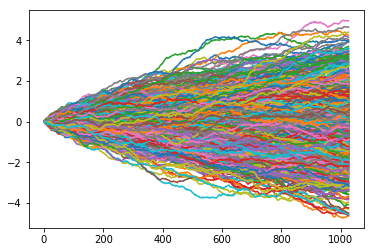

In [16]:
# Visualization
Nrange = range(1, N+2)
for i in range(m):
    plt.plot(Nrange, F[i])
plt.show()

To make sure that we have the right results, we will compare $\mathcal{Var}(B^H_2)$, $\mathcal{Var}(B^H_1)$ and $\mathcal{Cov}(B^H_2, B^H_1)$.

In [17]:
# theoretic results
print('Var(BH(2)) = %.4f' % (fbm.cov_pointwise(H, T, T)))
print('Var(BH(1)) = %.4f' % (fbm.cov_pointwise(H, T/2, T/2)))
print('Cov(BH(1), BH(2)) = %.4f' % (fbm.cov_pointwise(H, T/2, T)))

Var(BH(2)) = 2.6390
Var(BH(1)) = 1.0000
Cov(BH(1), BH(2)) = 1.3195


In [18]:
# simulated results
FT = F[:, -1]
FT_half = F[:, N >> 1]
cov_mat = np.cov(FT, FT_half)
# theoretic results
print('Var(BH(2)) = %.4f' % (cov_mat[0][0]))
print('Var(BH(1)) = %.4f' % (cov_mat[1][1]))
print('Cov(BH(1), BH(2)) = %.4f' % (cov_mat[0][1]))

Var(BH(2)) = 2.5785
Var(BH(1)) = 1.0192
Cov(BH(1), BH(2)) = 1.3276


## Spectral Method

# Rough Volatility Model

In the paper [Volatility is rough](https://arxiv.org/pdf/1410.3394.pdf), the rough fraction volatility model (RFVM) is defined as following:

$(X_t)$ is defined as a fractional Ornstein-Uhlenbeck process (fOU), i.e. we replace the Brownian motion by a fractional Brownian motion in the vanilla Ornstein-Uhlenbeck process, which satisfies the SDE
$$d X_{t}=\nu d W_{t}^{H}-\alpha\left(X_{t}-m\right) d t$$
, where $\nu > 0$ and $\alpha > 0$. With exactly the same method to solve its vanilla counterpart, we write out the solution as a stochastic integral:
$$X_{t}=\nu \int_{0}^{t} e^{-\alpha(t-s)} d W_{t}^{H}+m,~t\in [0, T]$$

The volatility is defined by $\sigma_t := \exp {X_t}$ and for this reason, $X_t$ is called the \textbf{log-volatility}. Now we are going to simulate the log-volatility.

## Simulation of Log-volatility

To simulate the log-volatility, we first use the naive simulation of a stochastic integral. We take $N = 2^n + 1$ (the same as section 1) and let $ t_k = \frac{kT}{N},~ k = 0, 1, ..., N$. Then we approximate $\int_{0}^{t} e^{-\alpha(t-s)} d W_{t}^{H}$ by $$\sum_{i = 1}^{k} e^{-\alpha(t_{k}-t_{i - 1})} \left(W_{t_i}^{H} - W_{t_{i-1}}^H\right) = e^{-\alpha t_k} \sum_{i=1}^k e^{\alpha t_{i-1}} \left(W^H_{t_i} - W^H_{t_{i-1}}\right)$$

In [23]:
class fou:
    @staticmethod
    def fou_process(H=0.14, nu=0.3, m=-5, alpha=0.0005, T=2, n=9, M=1000):
        '''
        Simulates M copies of (X(0), X(T/N), ..., X(T)), N = 2^n+1, where X is a fOU process

        Parameters:
            H - Hurst exponent
            T - time span
            n - used in N = (2^n + 1), segments between 0 and T
            M - number of simulations
            nu - param in fOU
            alpha - param in fOU
            m - initial value of X

        Returns:
            a M-by-(N+1) matrix, every line is one sample of (X(0), X(T/N), ..., X(T))
        ''' 
        N = (1 << n) | 1
        h = T/N
        W = fbm.circulent_simulation(H, T, n, M)
        
        # Calculate $\exp(-\alpha t_k)$ for $k \in \{1, \dots, N\}$, as M-by-N matrix
        exp_of_minus_alpha_t_k = np.exp(-alpha*h*np.arange(1, N+1))
        
        # Calculate $\exp(\alpha*t_{i-1})$ for $i \in \{1, \dots, N\}$, as M-by-N matrix
        exp_of_alpha_t_i = np.exp(alpha*h*np.arange(N))
        
        # Calculate $\W^H_{t_i} - W^H_{t_{i-1}}$ for $\i \in \{1, \dots, N\}$, as M-by-N matrix
        diff_W_H_t_i = W[:, 1:] - W[:, :-1]
        
        cumsum_k_exp_of_alpha_t_i_times_diff_W_H_t_i = np.cumsum(exp_of_alpha_t_i * diff_W_H_t_i, axis = 1)
        
        res_fou = np.zeros((M, N+1))
        
        res_fou[:, 1:] = exp_of_minus_alpha_t_k * cumsum_k_exp_of_alpha_t_i_times_diff_W_H_t_i
        
        print(res_fou.shape)
        
        return res_fou

(1000, 514)


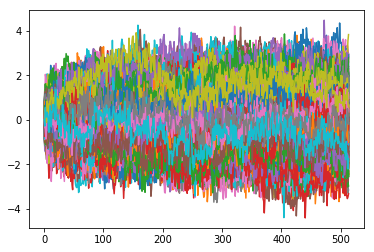

In [25]:
plt.plot(fou.fou_process().T)

In [222]:
a = np.arange(1, 5)
a = np.flip(a)
a

array([4, 3, 2, 1])